## Check List 7.1. Demo - White board sweeping
* In this demo file, we will use two robots (Indy7, Panda) to sweep a white board, removing obstacles

* You need trained model to use ReachChecker
  - model/reach_svm/indy7.json
  - model/reach_svm/panda.json
  - 백업: 개인 이동식 하드디스크, 강준수

### Prepare the task scene
* Prepare Indy7 and panda, and install sweeping tool to indy. (Check release/Figs/7.1.WhiteBoardSweeping.jpg)
* Prepare "floor", "track", "box1", "box2" objects as defined in pkg.detector.aruco.marker_config.py
* The robots and "track" are installed on "floor".
* "box1" and "box2" are on "track"
<img src="../Figs/7.1.WhiteBoardSweeping.jpg" width="80%">

## set running directory to project source

In [15]:
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

## init combined robot config

In [16]:
from pkg.controller.combined_robot import *
from pkg.project_config import *

crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7, ((0.0,-0.0,0), (0,0,0)),
                INDY_IP)]
              , connection_list=[False])

connection command:
indy0: False


## create scene builder

In [17]:
from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(None)
# s_builder.reset_reference_coord(ref_name="floor")

In [18]:
gscene = s_builder.create_gscene(crob)

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.


Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]


In [19]:
def read_file(filename):
    buffer = ""
    with open(filename, 'r') as f:
        while True:
            line = f.readline()
            buffer += line
            if not line: break
    return buffer

In [20]:
dat = read_file("./data/Test6.csv")

In [21]:
lines = dat.split("\n")
heads = lines[0].split(",")[:-1]
data_mat = []
for line in lines[1:]:
    data_line = list(map(float, line.split(",")[:-1]))
    if len(data_line)>0:
        data_mat.append(data_line)
data_mat = np.array(data_mat)

In [22]:
data_mat

array([[ 7.517840e-01, -5.929460e-01, -7.047990e-01, ..., -1.376000e-02,
         5.000000e-03,  6.000000e+01],
       [ 7.518460e-01, -5.929980e-01, -7.047170e-01, ..., -1.160000e-02,
         6.000000e-03,  6.000000e+01],
       [ 7.519070e-01, -5.930480e-01, -7.046380e-01, ..., -1.160000e-02,
         6.000000e-03,  6.000000e+01],
       ...,
       [ 3.819300e-02, -1.140060e-01, -1.684262e+00, ..., -2.758000e-02,
         4.500000e-03,  5.900000e+01],
       [ 3.817100e-02, -1.139430e-01, -1.684199e+00, ..., -2.442000e-02,
         5.500000e-03,  5.900000e+01],
       [ 3.815100e-02, -1.138810e-01, -1.684139e+00, ..., -2.442000e-02,
         5.500000e-03,  5.900000e+01]])

In [23]:
JOINT_DOF = 6

In [24]:
(heads[0:JOINT_DOF], heads[JOINT_DOF:JOINT_DOF*2], heads[JOINT_DOF*2:JOINT_DOF*3], heads[JOINT_DOF*3:JOINT_DOF*4], 
 heads[JOINT_DOF*4:JOINT_DOF*5], heads[JOINT_DOF*5:JOINT_DOF*6])

(['q0', 'q1', 'q2', 'q3', 'q4', 'q5'],
 ['qdot0', 'qdot1', 'qdot2', 'qdot3', 'qdot4', 'qdot5'],
 ['error0', 'error1', 'error2', 'error3', 'error4', 'error5'],
 ['e_nr0', 'e_nr1', 'e_nr2', 'e_nr3', 'e_nr4', 'e_nr5'],
 ['torque0', 'torque1', 'torque2', 'torque3', 'torque4', 'torque5'],
 ['Fext0', 'Fext1', 'Fext2', 'Fext3', 'Fext4', 'Fext5'])

In [25]:
idx = np.arange(len(data_mat))
# idx = np.arange(106215,106220)
q = data_mat[idx,0:JOINT_DOF]
e_dr = data_mat[idx,JOINT_DOF*2:JOINT_DOF*3]
e_nr = data_mat[idx,JOINT_DOF*3:JOINT_DOF*4]
Fext = data_mat[idx,JOINT_DOF*5:JOINT_DOF*6]
e_dn = e_dr-e_nr
q_d = q+e_dr
q_n = q+e_nr

In [26]:
from pkg.utils.joint_utils import *

In [27]:
inspect_arguments(get_tf)

(['to_link', 'joint_dict', 'urdf_content'], {'from_link': 'base_link'})

In [28]:
Fe_list = []
for i in range(len(q)):
    Tbe = get_tf("indy0_tcp", list2dict(q[i], gscene.joint_names), gscene.urdf_content)
    Fe = np.matmul(Tbe[:3,:3].transpose(), Fext[i,:3])
    Fe_list.append(Fe)

In [29]:
import matplotlib.pyplot as plt

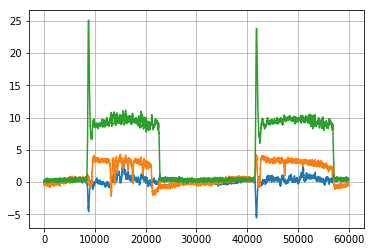

In [30]:
plt.plot(np.negative(Fe_list))
plt.grid(True)

In [34]:
import numpy as np
np.savetxt('ForceData.csv',Fe_list,delimiter=",")